# ML for Context in AI Assistant


In [1]:
# Import libraries and files
import pandas as pd
import math

from src.Utils import *
import matplotlib.pyplot as plt
from src.config import *

C:\Users\aopre\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 1 - Embeddings-based search engine

First, I load in a pre-trained model from HuggingFace using the load_model method, the all_MiniLM-L6-v2. Here, I also specify 3 dummy files to search over, which are stored in the demo_files.

In [2]:
# Load model and specify the documents to use for the demo
model = load_model(device)

DOCUMENT_FILENAMES = ["demo_files/sort_utils.py", "demo_files/api_client.py", "demo_files/file_parser.py"]

Loading fine-tuned model: None


Below are two helper methods. The create_search_index() method reads the documents provided to it, creates their embedding by encoding them using the model and then creates a vector index using the FAISS library. The search() method, given a query, will encode it and search over the index to find the most similar file (I am returning only 1 result for now). 


In [3]:
def create_search_index_demo(filenames):
    """
    Reads documents, generates embeddings, and builds a FAISS index.
    """
    documents = []
    # Map the index-position back to the filename
    index_to_filename = {}

    print(f"Loading and indexing {len(filenames)} documents...")
    
    # Get the filenames
    for i, filename in enumerate(filenames):
        try:
            # Open the file and read its contents
            with open(filename, 'r', encoding='utf-8') as f:
                content = f.read()
                documents.append(content)
                index_to_filename[i] = filename
        except FileNotFoundError:
            print(f"Warning: File not found: {filename}. Skipping.")
        except Exception as e:
            print(f"Error reading {filename}: {e}. Skipping.")

    if not documents:
        print("No documents were loaded. Exiting.")
        return None, None, None

    # Generate embeddings for all documents
    print("Generating embeddings...")
    doc_embeddings = model.encode(documents, show_progress_bar=True)

    # Get the dimensionality of the embeddings
    d = doc_embeddings.shape[1]

    # Create a FAISS index (IndexFlatL2) that performs Euclidian distance search.
    index = faiss.IndexFlatL2(d)

    # Add the document embeddings to the index
    index.add(doc_embeddings)

    print(f"Index created successfully with {index.ntotal} documents.")
    return index, documents, index_to_filename

def search_demo(query_text, index, index_to_filename, all_documents, k=1):
    """
    Provides the "API" to search the index.

    Returns a list of search results
    """
    if not index:
        print("Index is not initialized.")
        return []

    # Generate embedding for the query
    query_embedding = model.encode([query_text])

    # Search the index and get the result indices
    distances, indices = index.search(query_embedding, k)

    # Format and return the results
    results = []
    for i in indices[0]:  # Iterate through the top-k indices
        filename = index_to_filename[i]
        content = all_documents[i]
        results.append({
            "filename": filename,
            "content_snippet": content[:300] + "..." # Show a snippet
        })
    return results

Now, I am going to demonstrate the functionality of the search engine on these 3 documents by giving it 3 queries and looking at the top result.

In [4]:
index, all_documents, index_to_filename = create_search_index_demo(DOCUMENT_FILENAMES)

queries = ["How to make an API", "How to parse files", "How to make a sorting method"]
if index:
    # Demonstrate the work of the search engine on test samples
    for query in queries:
        # Use the search "API"
        search_results = search_demo(query, index, index_to_filename, all_documents)
        
        print(f"\n--- Top {len(search_results)} results for '{query}' ---")
        if not search_results:
            print("No results found.")
        
        for res in search_results:
            print(f"\n[File: {res['filename']}]")
            print(res['content_snippet'])
            print("-" * 20)

Loading and indexing 3 documents...
Generating embeddings...


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Index created successfully with 3 documents.

--- Top 1 results for 'How to make an API' ---

[File: demo_files/api_client.py]
# api_client.py
# A function to fetch data from a web API

import requests
import json

def get_user_data(user_id):
    """
    Fetches user data from a public API (JSONPlaceholder).
    """
    try:
        url = f"https://jsonplaceholder.typicode.com/users/{user_id}"
        response = requests.ge...
--------------------

--- Top 1 results for 'How to parse files' ---

[File: demo_files/file_parser.py]
# file_parser.py
# A script to read and parse CSV files.

import csv

def parse_csv_file(filepath):
    """
    Reads a CSV file and returns a list of dictionaries.
    """
    data = []
    try:
        with open(filepath, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(fil...
--------------------

--- Top 1 results for 'How to make a sorting method' ---

[File: demo_files/sort_utils.py]
# sort_utils.py
# A collection of simple sorting

For each query, the relevant document was retrieved by the embedding-based search_engine.

## Task 2 - Evaluation

To evaluate this model, I will first import the CoSQA dataset.

The CoSQA dataset provided with the task showed strange values (https://huggingface.co/datasets/CoIR-Retrieval/cosqa), which were not representative of a search-engine task.
Therefore, I got another CoSQA dataset from HuggingFace that offered data fit for the task at hand:
https://huggingface.co/datasets/gonglinyuan/CoSQA/viewer/default/validation?views%5B%5D=validation

In [5]:
# ---- Loading the Dataset ----

# specify the train/val split for this dataset
splits = {'train': 'cosqa-train.json', 'validation': 'cosqa-dev.json'}

# get train and val CoSQA datasets
print("Loading CoSQA dataset...")
train_raw = pd.read_json("hf://datasets/gonglinyuan/CoSQA/" + splits["train"])
val_raw = pd.read_json("hf://datasets/gonglinyuan/CoSQA/" + splits["validation"])

train_set = format_train_dataset(val_raw, display_data=DEBUGGING)
val_set = format_test_dataset(val_raw, display_data=DEBUGGING)

Loading CoSQA dataset...


For the implementation of metrics, I created the Metrics class below. The class accepts the top k results returned by the model and the target result.
By calling recall_10(), mrr_10() and ndgc_10(), you can get the metrics for the given query result.

Since I only considered if the correct answer was in the top 10 (i.e. the other answers in the top 10 did not have a relevance score), the following calculations were performed.

*RECALL@10:* This now essentially becomes ACCURACY@10.   
If the answer is in the top 10, the metric is 1.   
Otherwise, 0.  

*MRR@10:*  
If target answer in top 10: return 1/rank  
If target answer not in top 10: return 0  

*NDGC@10:*  
If target answer in top 10: return '1 / math.log(rank + 1, 2)'  
If target answer not in top 10: return 0  

In [6]:

class Metrics:
    def __init__(self, results, target):
        self.results = results
        self.target = target

    @property
    def recall_10(self):
        """
        Performs the RECALL@10 accuracy metric calculation on the guesses of the model
        Since we consider only the target answer, we are essentially performing Accuracy@10

        :return:
        If target answer in top 10: return 1
        If target answer not in top 10: return 0
        """
        # Get answers from the results dict
        answers = [answer["filename"] for answer in self.results]

        return 1 if self.target in answers else 0

    @property
    def mrr_10(self):
        """
        Performs the MRR@10 accuracy metric calculation on the guesses of the model
        Since we consider only the target answer, it effectively becomes 1/rank

        :return:
        If target answer in top 10: return 1/rank
        If target answer not in top 10: return 0
        """
        # Get answers and rank of guess from the results dict
        answers = [answer["filename"] for answer in self.results]
        if self.target not in answers:
            return 0

        rank = answers.index(self.target) + 1
        return 1 ** (1 / rank)

    @property
    def ndcg_10(self):
        """
        Performs the NDCG@10 accuracy metric calculation on the guesses of the model
        NDCG = DCG / IDCG

        Since we consider only the target answer, it effectively becomes DCG

        :return:
        If target answer in top 10: return DCG
        If target answer not in top 10: return 0
        """

        # Get answers and rank of guess from the results dict
        answers = [answer["filename"] for answer in self.results]
        if self.target not in answers:
            return 0

        rank = answers.index(self.target) + 1
        ndcg = 1 / math.log(rank + 1, 2)

        return ndcg

    @staticmethod
    def get_averages(all_metrics):
        # Calculate the means of each metric
        recalls = [metric.recall_10 for metric in all_metrics]
        mrrs = [metric.mrr_10 for metric in all_metrics]
        ndgcs = [metric.ndcg_10 for metric in all_metrics]

        return sum(recalls)/len(recalls), sum(mrrs)/len(mrrs), sum(ndgcs)/len(ndgcs)

    def __str__(self):
        return f"RECALL@10 {self.recall_10} \nMRR@10 {self.mrr_10} \nNDCG@10 {self.ndcg_10}"


In the method "search_engine_test()", for each query in the validation set, the 3 metrics are calculated.

The search() and create_search_index() methods are the same as the dummy versions above, but tweaked to work with the CoSQA dataset.
To get the average of each metric, the "get_averages(all_metrics)" method is used in the Metrics class, which returns the averages in a 3-tuple




In [7]:

def search(query_text, index, model, index_to_filename, all_documents, k=10, display=False):
    """
    Provides the "API" to search the index.

    Returns a list of search results.
    """
    if not index:
        print("Index is not initialized.")
        return []

    # Generate an embedding for the query
    query_embedding = model.encode([query_text])
    
    # Search the index
    distances, indices = index.search(query_embedding, k)
    if display:
        display_distances_ranks(distances[0], indices[0])

    # Return the results
    results = []
    for i in indices[0]:
        filename = index_to_filename[i]
        content = all_documents[i]
        results.append({
            "filename": filename,
            "content_snippet": content[:512] + "..."  # Show a snippet
        })
    return results


def create_search_index(df, model):
    """
    Reads documents, generates embeddings, and builds a FAISS index.
    """
    documents = []
    # We need to map the index-position back to the filename
    index_to_filename = {}

    print(f"Loading and indexing {len(df)} documents...")

    # row structure: idx, doc, code, code_tokens, docstring_tokens, label
    for index, row in df.iterrows():
        code = row["code"]
        documents.append(code)
        index_to_filename[index] = row["idx"]

    if not documents:
        print("No documents were loaded. Exiting.")
        return None, None, None

    # Generate embeddings for all documents
    print("Generating embeddings...")
    doc_embeddings = model.encode(documents, show_progress_bar=True)

    # Get the dimensionality of the embeddings
    dimensions = doc_embeddings.shape[1]

    # Create FAISS IndexFlatL2 index: performs brute-force Euclidean distance search.
    index = faiss.IndexFlatL2(dimensions)
    index.add(doc_embeddings)

    print(f"Index created successfully with {index.ntotal} documents.")
    return index, documents, index_to_filename

In [8]:

def search_engine_test(model, val_raw, val_set, display = False):
    # Run the model on the validation set and collect and calculate the evaluation metrics
    print("Testing the model on the validation data... ")
    index, all_documents, index_to_filename = create_search_index(val_raw, model)
    val_metrics = []
    
    for idx, query, code in val_set:
        # Get search results for current query.
        search_results = search(query, index, model, index_to_filename, all_documents, display=display)
        
        # Calculate metrics and store them.
        metrics = Metrics(search_results, idx)
        val_metrics.append(metrics)
        
        if display:
            print(f"IDX: {idx}")
            print("")

    # Calculate the average evaluation metrics
    recall_avg, mrr_avg, ndgc_avg = Metrics.get_averages(val_metrics)
    
    return recall_avg, mrr_avg, ndgc_avg

Let's run search_engine_test() to get the test results

In [9]:
# Test the model and print metrics
recall_avg, mrr_avg, ndgc_avg = search_engine_test(model, val_raw, val_set)

print(f"RECALL@10 AVERAGE: {recall_avg}")
print(f"MRR@10 AVERAGE: {mrr_avg}")
print(f"NDGC@10 AVERAGE: {ndgc_avg}")

Testing the model on the validation data... 
Loading and indexing 604 documents...
Generating embeddings...


Batches: 100%|██████████| 19/19 [00:00<00:00, 23.29it/s]


Index created successfully with 604 documents.
RECALL@10 AVERAGE: 0.9668874172185431
MRR@10 AVERAGE: 0.9668874172185431
NDGC@10 AVERAGE: 0.804717351117915



For the untrained model, these are the following metrics on the validation set:

RECALL@10 AVERAGE: 0.9668874172185431  
MRR@10 AVERAGE: 0.9668874172185431  
NDGC@10 AVERAGE: 0.804717351117915  


## Task 3: Fine-tuning


After plotting a histogram of the lengths of the code examples, I saw that there was a great amount that had between 256 and 512 characters (and even more with less than 256 characters). 
Since the model (by default) truncates the input to 256 characters, I truncated the inputs at 512 characters for better accuracy.


MIN LENGTH   |   MAX LENGTH:  87 6395


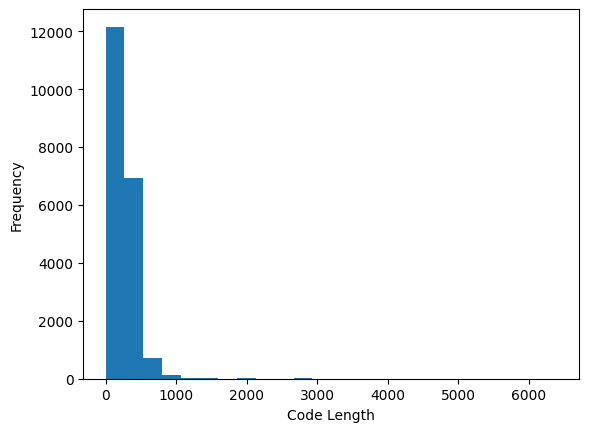

--- Using device: cuda ---


In [10]:
# ---- Examining the dataset ----

code_lengths = [len(x) for x in train_raw["code"].values]
print("MIN LENGTH   |   MAX LENGTH: ", min(code_lengths), max(code_lengths))

# Get the number of bins we should group the counts in. Bins are in intervals of 256
n_bins = (max(code_lengths)) // 256

plt.hist(code_lengths, range=(0, max(code_lengths)), bins = n_bins)
plt.xlabel("Code Length")
plt.ylabel("Frequency")
plt.show()

print(f"--- Using device: {device} ---")

# Specify params for training
train_params = {"batch_size": 16, "input_length": 512, "lr": 0.00002, "shuffle": True, "epochs": 5, "warmup": 50}


Below is the training routine for the model. For the loss function, I chose the MultipleNegativesRankingLoss. This loss "pulls" the anchor to its code example closer, and "pushes" the anchor away from the other positive examples from its batch.
This helps the model to get better at distinguishing between relevant and irrelevant code samples for the given query, which is why I chose it.

In [11]:
def search_engine_train(model, train_params, train_set):
    print(f"Using device: {device}")

    # Prepare the DataLoader
    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=train_params["batch_size"])
    train_dataloader.collate_fn = model.smart_batching_collate

    # Create loss function
    train_loss = losses.MultipleNegativesRankingLoss(model=model).to(device)
    
    # Create Optimizer
    optimizer = AdamW(model.parameters(), lr=train_params["lr"])

    # Prepare Scheduler 
    num_epochs = train_params["epochs"]
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=train_params["warmup"],
                                                num_training_steps=total_steps)
    # Create plot for the losses
    plt.title("Losses per Step")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Store the average losses
    average_losses = []

    # Store losses for line of best fit
    all_step_losses_combined = []

    # Set model to training mode
    print("Starting fine-tuning process...")
    model.train()

    for epoch in range(num_epochs):
        print(f"\nEpoch: {epoch}")
        all_step_losses_epoch = []

        step = 1
        for batch in train_dataloader:
            features, labels = batch

            # Move batch to device
            features = list(map(lambda batch_item: {k: v.to(device) for k, v in batch_item.items()}, features))
            labels = labels.to(device) if labels is not None else None

            optimizer.zero_grad()

            # Calculate losses and gradients
            loss_value = train_loss(features, labels)
            loss_value.backward()

            # Do a step for the optimizer and scheduler
            optimizer.step()
            scheduler.step()

            # Get the losses to plot later
            current_loss = loss_value.item()
            all_step_losses_epoch.append(current_loss)
            all_step_losses_combined.append(current_loss)

            # Count steps for logging
            if step % 10 == 0:
                print(f"Step: {step}")
            step += 1

        # Plot the losses for intermediate steps
        plt.plot(all_step_losses_epoch, label=f"Epoch: {epoch+1}")

        # Store the average loss for this epoch
        average_losses.append(sum(all_step_losses_epoch) / len(all_step_losses_epoch))

    # Plot the losses per epoch
    plt.legend()
    plt.show()

    print("Training complete.")

    # Save the model
    model.save(f'./cosqa-finetuned-model-{train_params.values()}')

    print(f"\nCaptured {len(average_losses)} step losses.")

    # Plot average losses
    plt.plot(average_losses)
    plt.title("Training Loss per Epoch")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.show()

Now lets train the model on the CoSQA dataset, and plot the loss values per step and epoch.

Using device: cuda
Starting fine-tuning process...

Epoch: 0
Step: 10
Step: 20
Step: 30

Epoch: 1
Step: 10
Step: 20
Step: 30

Epoch: 2
Step: 10
Step: 20
Step: 30

Epoch: 3
Step: 10
Step: 20
Step: 30

Epoch: 4
Step: 10
Step: 20
Step: 30


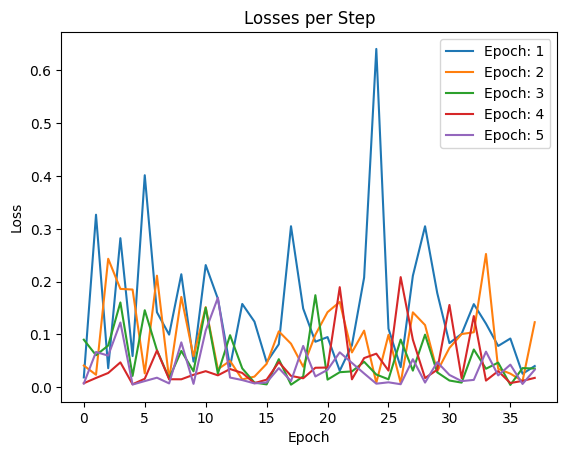

Training complete.

Captured 5 step losses.


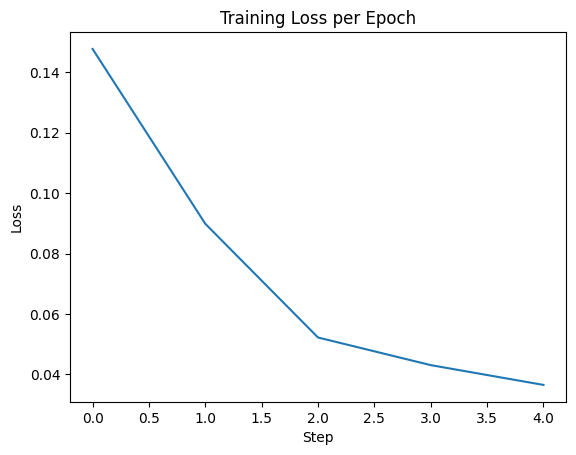

In [12]:
search_engine_train(model, train_params, train_set)


As can be seen from the second graph, the losses decrease as the model trains on more epochs, showing that it gets more accurate.


Next, let's re-evaluate the model and display the metrics.

In [13]:
recall_avg, mrr_avg, ndgc_avg = search_engine_test(model, val_raw, val_set, display=DEBUGGING)

print(f"RECALL@10 AVERAGE: {recall_avg}")
print(f"MRR@10 AVERAGE: {mrr_avg}")
print(f"NDGC@10 AVERAGE: {ndgc_avg}")

Testing the model on the validation data... 
Loading and indexing 604 documents...
Generating embeddings...


Batches: 100%|██████████| 19/19 [00:00<00:00, 29.52it/s]


Index created successfully with 604 documents.
RECALL@10 AVERAGE: 1.0
MRR@10 AVERAGE: 1.0
NDGC@10 AVERAGE: 0.8962659431830238


After training the model, the metrics considerably improve:

RECALL@10 AVERAGE: 1.0  
MRR@10 AVERAGE: 1.0  
NDGC@10 AVERAGE: 0.8846501701246057

This was done with the following hyperparameters:

batch size: 16  
input length: 512  
learning rate: 0.00002  
shuffle: True  
epochs: 5  
warmup: 50  


I was also curious to see how the model would do with an input length of 256. 

Loading fine-tuned model: None
Using device: cuda
Starting fine-tuning process...

Epoch: 0
Step: 10
Step: 20
Step: 30

Epoch: 1
Step: 10
Step: 20
Step: 30

Epoch: 2
Step: 10
Step: 20
Step: 30

Epoch: 3
Step: 10
Step: 20
Step: 30

Epoch: 4
Step: 10
Step: 20
Step: 30


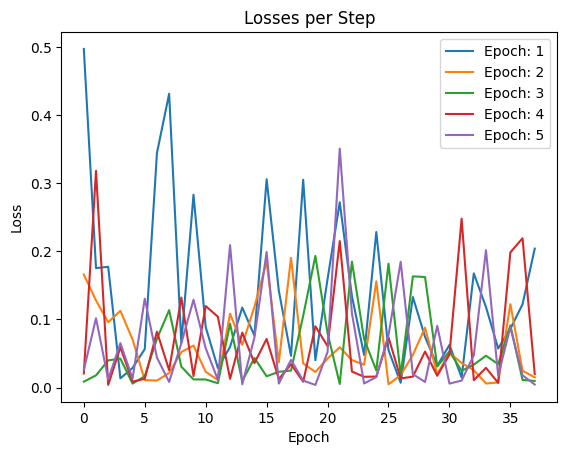

Training complete.

Captured 5 step losses.


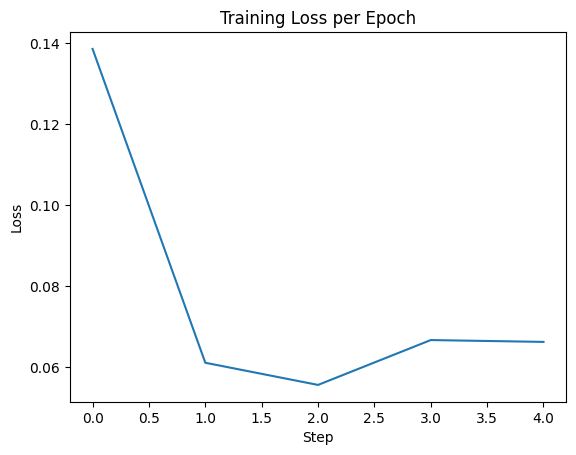

Testing the model on the validation data... 
Loading and indexing 604 documents...
Generating embeddings...


Batches: 100%|██████████| 19/19 [00:00<00:00, 29.59it/s]


Index created successfully with 604 documents.
RECALL@10 AVERAGE: 1.0
MRR@10 AVERAGE: 1.0
NDGC@10 AVERAGE: 0.891705033808003


In [14]:
train_params = {"batch_size": 16, "input_length": 256, "lr": 0.00002, "shuffle": True, "epochs": 5, "warmup": 50}

model = load_model(device)

search_engine_train(model, train_params, train_set)
recall_avg, mrr_avg, ndgc_avg = search_engine_test(model, val_raw, val_set, display=DEBUGGING)

print(f"RECALL@10 AVERAGE: {recall_avg}")
print(f"MRR@10 AVERAGE: {mrr_avg}")
print(f"NDGC@10 AVERAGE: {ndgc_avg}")



These are the metrics:

RECALL@10 AVERAGE: 1.0  
MRR@10 AVERAGE: 1.0  
NDGC@10 AVERAGE: 0.8905926708414873

Even though the NDGC@10 does increase slightly, it's not a big difference. Running this script multiple times will show that the accuracies vary every training cycle, and they are pretty much the same for both input lengths. Therefore, the input length does not affect the model's accuracy substantially (at least for this dataset).


## Bonus Tasks

To see how the metrics change when we apply the model only on function names, I will update the create_search_index method to take only the method name first:

In [15]:

import re

def create_search_index(df, model):
    """
    Reads documents, generates embeddings, and builds a FAISS index.
    """
    documents = []
    # We need to map the index-position back to the filename
    index_to_filename = {}
    
    # Making the RE expression to only get the method names.
    pattern = re.compile(r"def\s+([a-zA-Z_][a-zA-Z0-9_]*)\s*\(")

    print(f"Loading and indexing {len(df)} documents...")

    # row structure: idx, doc, code, code_tokens, docstring_tokens, label
    for index, row in df.iterrows():
        match = pattern.search(row["code"])
        
        if match:
            # Get the content of the first capturing group
            method_name = match.group(1)
            code = method_name
            documents.append(code)
            index_to_filename[index] = row["idx"]

    if not documents:
        print("No documents were loaded. Exiting.")
        return None, None, None

    # Generate embeddings for all documents
    print("Generating embeddings...")
    doc_embeddings = model.encode(documents, show_progress_bar=True)

    # Get the dimensionality of the embeddings
    dimensions = doc_embeddings.shape[1]

    # Create a FAISS index: performs brute-force L2 (Euclidean) distance search.
    index = faiss.IndexFlatL2(dimensions)
    index.add(doc_embeddings)

    print(f"Index created successfully with {index.ntotal} documents.")
    return index, documents, index_to_filename


Now, let's train a new model on this new dataset

Loading fine-tuned model: None
Using device: cuda
Starting fine-tuning process...

Epoch: 0
Step: 10
Step: 20
Step: 30

Epoch: 1
Step: 10
Step: 20
Step: 30

Epoch: 2
Step: 10
Step: 20
Step: 30

Epoch: 3
Step: 10
Step: 20
Step: 30

Epoch: 4
Step: 10
Step: 20
Step: 30


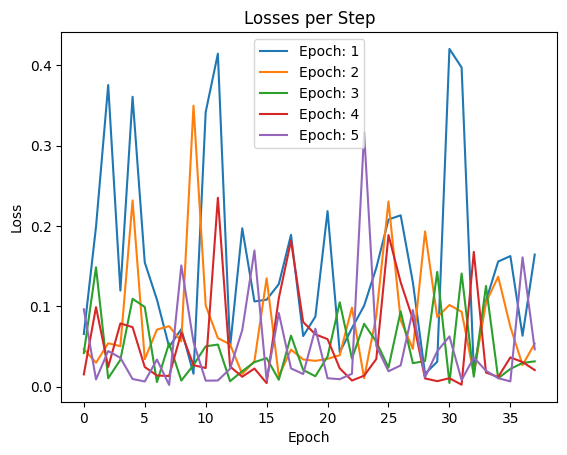

Training complete.

Captured 5 step losses.


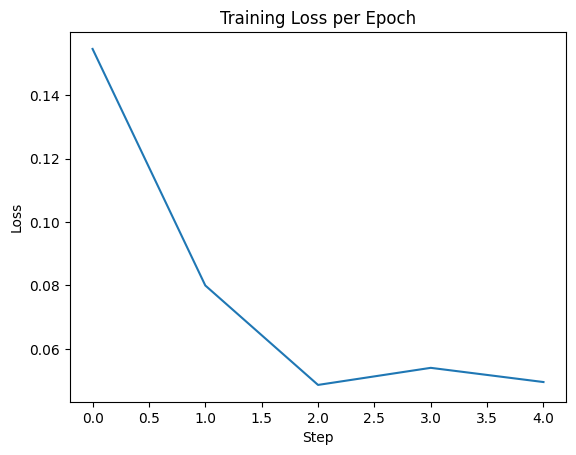

Testing the model on the validation data... 
Loading and indexing 604 documents...
Generating embeddings...


Batches: 100%|██████████| 19/19 [00:00<00:00, 61.06it/s]


Index created successfully with 604 documents.


(0.7086092715231788, 0.7086092715231788, 0.5279509142332892)

In [16]:
model = load_model(device)

search_engine_train(model, train_params, train_set)
search_engine_test(model, val_raw, val_set, display=DEBUGGING)

Now, the metrics are substantially lower, even after training. This was expected, since the documents (now method names) are less descriptive, meaning that their vector representations may not be as precise as they could be.

RECALL@10 AVERAGE: 0.7152317880794702  
MRR@10 AVERAGE: 0.7152317880794702  
NDGC@10 AVERAGE: 0.5301269442750365  

Now, to see how the metrics change based on the hyperparameters of the index, I will change the search and the create_search_index methods for a more customizable index

In [17]:
def create_search_index(df, model, M=16):
    """
    Reads documents, generates embeddings, and builds a FAISS index.
    """
    documents = []
    # We need to map the index-position back to the filename
    index_to_filename = {}
    
    # Making the RE expression to only get the method names.
    pattern = re.compile(r"def\s+([a-zA-Z_][a-zA-Z0-9_]*)\s*\(")

    print(f"Loading and indexing {len(df)} documents...")

    # row structure: idx, doc, code, code_tokens, docstring_tokens, label
    for index, row in df.iterrows():
        match = pattern.search(row["code"])
        
        if match:
            # Get the content of the first capturing group
            method_name = match.group(1)
            code = method_name
            documents.append(code)
            index_to_filename[index] = row["idx"]

    if not documents:
        print("No documents were loaded. Exiting.")
        return None, None, None

    # Generate embeddings for all documents
    print("Generating embeddings...")
    doc_embeddings = model.encode(documents, show_progress_bar=True)

    # normalize the embeddings (the new vector index will not work well without this)
    faiss.normalize_L2(doc_embeddings)

    # Get the dimensionality of the embeddings
    dimensions = doc_embeddings.shape[1]

    # Create a tunable HNSW index instead of IndexFlatL2
    # M = The number of connections per node (default 16). Higher = better accuracy.
    index = faiss.IndexHNSWFlat(dimensions, M, faiss.METRIC_INNER_PRODUCT)
    index.add(doc_embeddings)
    
    print(f"Index created successfully with {index.ntotal} documents.")
    return index, documents, index_to_filename


def search(query_text, index, model, index_to_filename, all_documents, k=10, efSearch=128, display=False):
    """
    Provides the "API" to search the index.
    
    Returns list of search results.
    """
    if not index:
        print("Index is not initialized.")
        return []

    # Generate an embedding for the query
    query_embedding = model.encode([query_text])

    # Normalize the query embedding
    faiss.normalize_L2(query_embedding)

    # Set the search-time hyperparameter
    index.hnsw.efSearch = efSearch

    # Search the index
    distances, indices = index.search(query_embedding, k)
    if display:
        display_distances_ranks(distances[0], indices[0])

    # Return the results
    results = []
    for i in indices[0]:
        filename = index_to_filename[i]
        content = all_documents[i]
        results.append({
            "filename": filename,
            "content_snippet": content[:512] + "..."  # Show a snippet
        })
    return results



Now that the two methods are able to change the vector hyperparameters, lets change them. By default, efSearch = 128 (depth of vector index search). Therefore, I will change its values to see how it affects the results. I will do this on the untrained model. I will also update the search_engine_test() method to accept different embedding sizes.

In [18]:

def search_engine_test(model, val_raw, val_set, efSearch=128, display = False):
    # Run the model on the validation set and collect and calculate the evaluation metrics
    print("Testing the model on the validation data... ")
    index, all_documents, index_to_filename = create_search_index(val_raw, model, M=16)
    val_metrics = []

    for idx, query, code in val_set:
        if display:
            print(f"IDX: {idx}")
            print("")

        search_results = search(query, index, model, index_to_filename, all_documents, efSearch=efSearch, display=display)
        metrics = Metrics(search_results, idx)
        val_metrics.append(metrics)


    # Calculate the average evaluation metrics
    recall_avg, mrr_avg, ndgc_avg = Metrics.get_averages(val_metrics)

    # Returns the metrics of the model
    return recall_avg, mrr_avg, ndgc_avg

Below, the model is being run with different efSearch values (16, 32, 64, 128, 256). efSearch defines how thorough the searches for the index are. Higher values should find the correct result in the index more often than lower efSearch values.

Loading fine-tuned model: None
Loading and indexing 604 documents...
Generating embeddings...


Batches: 100%|██████████| 19/19 [00:00<00:00, 38.81it/s]


Index created successfully with 604 documents.

--- Testing with efSearch = 16 ---
Testing the model on the validation data... 
Loading and indexing 604 documents...
Generating embeddings...


Batches: 100%|██████████| 19/19 [00:00<00:00, 69.16it/s]


Index created successfully with 604 documents.
RECALL@10 AVERAGE: 0.6175496688741722
MRR@10 AVERAGE: 0.6175496688741722
NDGC@10 AVERAGE: 0.47015721585186765

--- Testing with efSearch = 32 ---
Testing the model on the validation data... 
Loading and indexing 604 documents...
Generating embeddings...


Batches: 100%|██████████| 19/19 [00:00<00:00, 67.03it/s]


Index created successfully with 604 documents.
RECALL@10 AVERAGE: 0.6307947019867549
MRR@10 AVERAGE: 0.6307947019867549
NDGC@10 AVERAGE: 0.4811115474164915

--- Testing with efSearch = 64 ---
Testing the model on the validation data... 
Loading and indexing 604 documents...
Generating embeddings...


Batches: 100%|██████████| 19/19 [00:00<00:00, 57.99it/s]


Index created successfully with 604 documents.
RECALL@10 AVERAGE: 0.640728476821192
MRR@10 AVERAGE: 0.640728476821192
NDGC@10 AVERAGE: 0.48632598458948845

--- Testing with efSearch = 128 ---
Testing the model on the validation data... 
Loading and indexing 604 documents...
Generating embeddings...


Batches: 100%|██████████| 19/19 [00:00<00:00, 59.43it/s]


Index created successfully with 604 documents.
RECALL@10 AVERAGE: 0.6440397350993378
MRR@10 AVERAGE: 0.6440397350993378
NDGC@10 AVERAGE: 0.48850390657092185

--- Testing with efSearch = 256 ---
Testing the model on the validation data... 
Loading and indexing 604 documents...
Generating embeddings...


Batches: 100%|██████████| 19/19 [00:00<00:00, 64.42it/s]


Index created successfully with 604 documents.
RECALL@10 AVERAGE: 0.6440397350993378
MRR@10 AVERAGE: 0.6440397350993378
NDGC@10 AVERAGE: 0.48850390657092185


[]

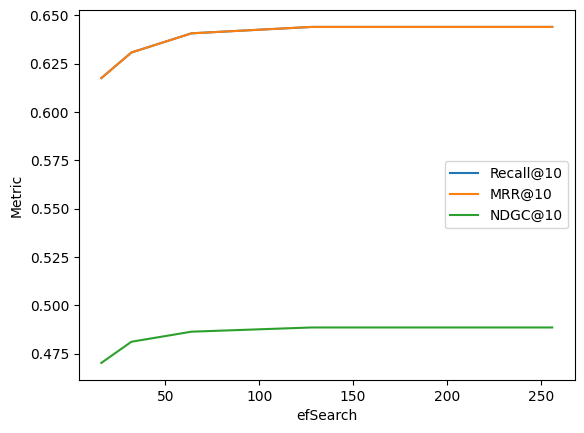

In [19]:
# Load model and build index
model = load_model(device)
index, all_documents, document_ids = create_search_index(val_raw, model, M=16)

recalls = []
mrrs = []
ndgcs = []
# Loop over efSearch values
for ef in [16, 32, 64, 128, 256]:
    print(f"\n--- Testing with efSearch = {ef} ---")
    
    # You need to modify search_engine_test to accept 'index' and 'efSearch'
    recall_avg, mrr_avg, ndgc_avg = search_engine_test(model, val_raw, val_set, efSearch=ef)
    
    print(f"RECALL@10 AVERAGE: {recall_avg}")
    print(f"MRR@10 AVERAGE: {mrr_avg}")
    print(f"NDGC@10 AVERAGE: {ndgc_avg}")
    
    recalls.append(recall_avg)
    mrrs.append(mrr_avg)
    ndgcs.append(ndgc_avg)

plt.plot([16, 32, 64, 128, 256], recalls, label="Recall@10")
plt.plot([16, 32, 64, 128, 256], mrrs, label="MRR@10")
plt.plot([16, 32, 64, 128, 256], ndgcs, label="NDGC@10")
plt.xlabel("efSearch")
plt.ylabel("Metric")
plt.legend()
plt.plot()

We indeed see that increasing the efSearch hyperparameter of the index does result in higher metric results. However, there is no significant improvement in performance after ef = 64.